In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams.update({"axes.grid" : True, "grid.color": "black"})
import sys # Для sys.exit()
from sklearn.model_selection import train_test_split


from keras.preprocessing.image import ImageDataGenerator

2021-09-28 20:54:49.008920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-28 20:54:49.008969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [105]:
def img_show(arr):
    plt.figure(figsize=(20,10))
    plt.imshow(arr)
    plt.show()
    
def plot_lern(history, val_q = 'accuracy'):
    # summarize history for accuracy
    plt.plot(history.history[val_q])
    plt.plot(history.history['val_' + val_q])
    plt.title('model ' + val_q)
    plt.ylabel(val_q)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
path_data = '../data/memotion_dataset_7k/'
path_labl = path_data + 'labels.csv'
path_img = path_data + 'images/'

In [4]:
drop_list = [5118, 1566, 4923, 6356, 6676, 6765]
# drop_list = [5118]
df_in = pd.read_csv(path_labl)
df_in = df_in.drop(index = drop_list)
df_in['first_word'] = df_in['text_ocr'] \
        .str.lower() \
        .str.extract('([a-z]+)', expand = False).fillna('')
df_in['first_sign'] = df_in['first_word'].str[0].fillna('')
df_in = df_in[['text_ocr', 'image_name','first_sign', 'first_word']]
df_in

,text_ocr,image_name,first_sign,first_word
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,image_1.jpg,l,look
1,The best of #10 YearChallenge! Completed in le...,image_2.jpeg,t,the
2,Sam Thorne @Strippin ( Follow Follow Saw every...,image_3.JPG,s,sam
3,10 Year Challenge - Sweet Dee Edition,image_4.png,y,year
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,image_5.png,y,year
...,...,...,...,...
6987,Tuesday is Mardi Gras Wednesday is Valentine's...,image_6988.jpg,t,tuesday
6988,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,image_6989.jpg,m,must
6989,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,image_6990.png,l,less
6990,When I VERY have time is a fantasy No one has ...,image_6991.jpg,w,when


## Проверка изображений

In [5]:
# from PIL import Image
# size = 128, 128
# for ind in df_in.index:
#     try:
        
#         im_path = path_img + df_in.loc[ind, 'image_name']
#         img = Image.open(im_path)
#         img.thumbnail(size, Image.ANTIALIAS)
#         if img.mode == 'P':
            
#             transparent = img.info.get("transparency", -1)
#             if transparent != -1:
#                 print(ind)
# #                 print(transparent)
#         img.convert('L')
#     except:
#         print(df_in.loc[ind])
# #     if ind > 5:
# #         break
# print('The and')

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def get_y_shape(ser):
    words_ser = ser.value_counts(dropna = False)
    max_len = int(words_ser.index.str.len().max())
    vectorizer = CountVectorizer(analyzer = 'char_wb')
    text_data = vectorizer.fit_transform(words_ser.index.dropna())
    count_signs = len(vectorizer.get_feature_names())
    print('Максимальная длинна слова / Количество оригинальных символов')
    print(max_len, '/', count_signs)
    return vectorizer, count_signs

vectorizer, num_classes = get_y_shape(df_in['first_word'])

Максимальная длинна слова / Количество оригинальных символов
21 / 27


In [7]:
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
le = OrdinalEncoder()

y_cols = ['y_' + str(i) for i in range(22)]
y = np.zeros((df_in.shape[0], len(y_cols))).astype(str)
y[y == '0.0'] = ''
for i, word in enumerate(df_in.first_word.values):
#     print(np.array(word))
#     print(len(word))
    y[i, 0:len(word)] = list(word)
y = le.fit_transform(y)
#     break
y

array([[12., 15., 15., ...,  0.,  0.,  0.],
       [20.,  8.,  5., ...,  0.,  0.,  0.],
       [19.,  1., 13., ...,  0.,  0.,  0.],
       ...,
       [12.,  5., 19., ...,  0.,  0.,  0.],
       [23.,  8.,  5., ...,  0.,  0.,  0.],
       [20.,  8.,  5., ...,  0.,  0.,  0.]])

In [8]:
print(len(np.unique(y)))
''.join(list(le.inverse_transform([y[2,:]])[0]))

27


'sam'

In [9]:
df = df_in[['image_name']]
df[y_cols] = y
df

/home/mikhaylov-yv/PycharmProjects/venvs/Ds_img_3.8/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,image_name,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_12,y_13,y_14,y_15,y_16,y_17,y_18,y_19,y_20,y_21
0,image_1.jpg,12.0,15.0,15.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,image_2.jpeg,20.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,image_3.JPG,19.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,image_4.png,25.0,5.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,image_5.png,25.0,5.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6987,image_6988.jpg,20.0,21.0,5.0,18.0,4.0,1.0,23.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6988,image_6989.jpg,13.0,21.0,19.0,19.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6989,image_6990.png,12.0,5.0,19.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6990,image_6991.jpg,23.0,8.0,5.0,14.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
random_state=42

train, test = train_test_split(
    df, test_size=0.33, random_state=random_state)
train.shape, test.shape

((4680, 23), (2306, 23))

In [11]:
2**8

256

In [12]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

random_state=42
size = 256, 256, 1
batch_size = 16

train_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory= path_img,
        x_col="image_name",
        y_col=y_cols,
        seed = random_state,
        color_mode = 'grayscale',
        subset="training",
        batch_size=batch_size,
        class_mode="raw",
        target_size=size[:-1],
        shuffle = True
)

validation_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory= path_img,
        x_col="image_name",
        y_col=y_cols,
        color_mode = 'grayscale',
        subset="validation",
        seed = random_state,
        batch_size=batch_size,
        class_mode="raw",
        target_size=size[:-1],
        shuffle = True
)


Found 5589 validated image filenames.
Found 1397 validated image filenames.


In [13]:
np.array(train_generator._targets).shape

(5589, 22)

In [14]:
from tensorflow import keras
import tensorflow as tf
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [100]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = (8,8),padding = 'Same', 
                 activation ='relu', input_shape = size),
#     keras.layers.Conv2D(filters = 8, kernel_size = (4,4),padding = 'Same', 
#                  activation ='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Dropout(0.25),


#     keras.layers.Conv2D(filters = 16, kernel_size = (8,8),padding = 'Same', 
#                      activation ='relu'),
#     keras.layers.Conv2D(filters = 4, kernel_size = (2,2),padding = 'Same', 
#                      activation ='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(4,4)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(22, activation = "softmax"),
])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 256, 256, 16)      1040      
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_114 (Dropout)        (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_115 (Dropout)        (None, 32, 32, 16)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_76 (Dense)             (None, 2)               

## len('1048608')

In [101]:
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=size),
# #     keras.layers.Conv2D(2, 3, activation='relu', input_shape = size),
# #     keras.layers.Conv2D(256, (3, 3), input_shape = size, activation='relu'),
#     keras.layers.Dense(128, activation=tf.nn.relu),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(22, activation=tf.nn.softmax)
# ])
# model.summary()

In [102]:
model.compile(optimizer=tf.optimizers.Adam(0.002), 
              loss='categorical_crossentropy',
              metrics=['mse'])

In [103]:
# X_, y_ = train_generator.next()
# model.fit(X_, y_,epochs=5)
# X_.shape, y_.shape

In [ ]:
history = model.fit(train_generator, epochs=5, 
                    validation_data = validation_generator
                   )


Epoch 1/5
350/350 [==============================] - 164s 468ms/step - loss: 94.2868 - mse: 32.8042 - val_loss: 99.6073 - val_mse: 34.6753
Epoch 2/5
350/350 [==============================] - 172s 492ms/step - loss: 92.5097 - mse: 32.7732 - val_loss: 98.1768 - val_mse: 34.6448
Epoch 3/5
350/350 [==============================] - 175s 499ms/step - loss: 91.2571 - mse: 32.7463 - val_loss: 97.2258 - val_mse: 34.6187
Epoch 4/5
350/350 [==============================] - 173s 495ms/step - loss: 90.3671 - mse: 32.7241 - val_loss: 96.6706 - val_mse: 34.5971
Epoch 5/5
328/350 [===========================>..] - ETA: 10s - loss: 89.9454 - mse: 32.7012

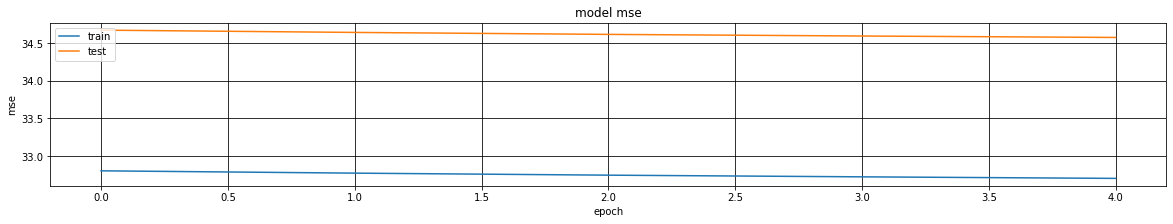

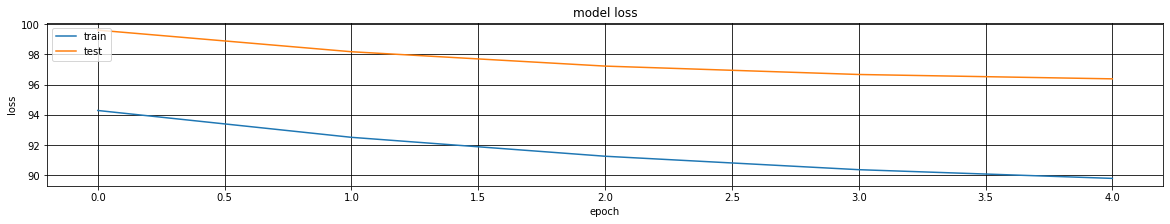

In [111]:
plot_lern(history, 'mse')

In [114]:

test_df = test#.sample(n=10, random_state=1)

test_generator=datagen.flow_from_dataframe(
        dataframe = test_df,
        directory= path_img,
        x_col="image_name",
        y_col=y_cols,
        color_mode = 'grayscale',
        batch_size=batch_size,
        class_mode="raw",
        target_size=size[:-1]
)

Found 2306 validated image filenames.


In [119]:
test_df_out = test_df[['image_name']]
test_df_out['pred'] = [''.join(word) for word in le.inverse_transform(model.predict(test_generator))]
test_df_out['tru'] =  df_in['first_word']
# test_df_out = test_df_out.loc[(test_df_out['pred'] != '')&(~test_df_out['pred'].isna())]
test_df_out


/tmp/ipykernel_13245/1902835423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_out['pred'] = [''.join(word) for word in le.inverse_transform(model.predict(test_generator))]
/tmp/ipykernel_13245/1902835423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_out['tru'] =  df_in['first_word']


,image_name,pred,tru
4981,image_4982.jpg,,friends
3072,image_3073.jpg,,obama
6221,image_6222.jpg,,there
3876,image_3877.png,,sergio
3867,image_3868.png,,your
...,...,...,...
5746,image_5747.jpg,,ive
4480,image_4481.jpg,,luke
2104,image_2105.jpg,,that
5522,image_5523.png,,i


In [109]:
from PIL import Image

In [ ]:
for ind in test_df_out.index:
    print(str(test_df_out.loc[ind, 'image_name']))
#     print(str(test_df_out.loc[ind, 'text_ocr']))
    print('True class: ', str(test_df_out.loc[ind, 'tru']))
    print('Pred class: ', str(test_df_out.loc[ind, 'pred']))
    im_path = path_img + test_df_out.loc[ind, 'image_name']
    img = Image.open(im_path)
    img_show(img)
#     img.show()